# Statsmodels

In this notebook, we look at some of the capability of [StatsModels](http://statsmodels.sourceforge.net/), a Python module developed by the Statistics department here at Stanford.

In [1]:
%matplotlib inline

import random

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_context("talk")

# Regression example with Iris data

Let's first look at a linear regression example using the Iris dataset. 
First, we read in the data.

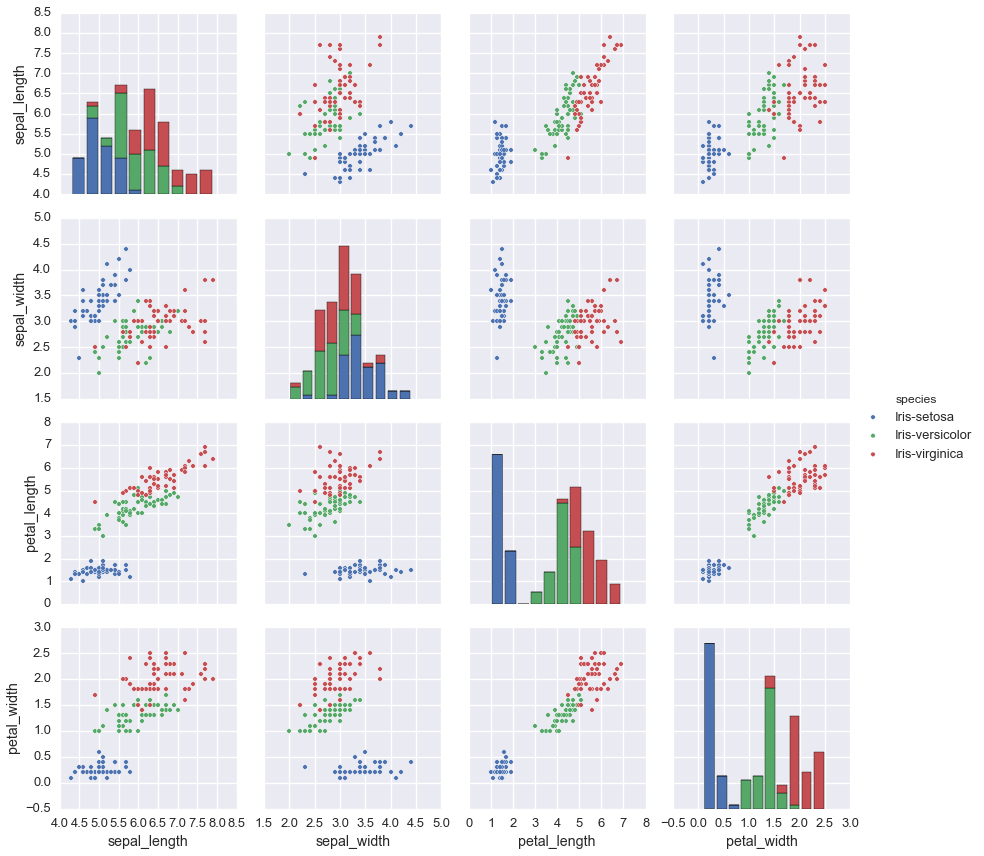

In [2]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                 header=None,
                 names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

sns.pairplot(iris, hue='species')

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Predicting sepal length

For educational purposes, let's assume that we are intested in predicting the sepal length given the other variables.

We split the data into a training and a test set, so that we can validate the performance on held out data

In [4]:
# number of observations
n = len(iris)
is_train = np.random.rand(n) < 0.7
train = iris[is_train].reset_index(drop=True)
test = iris[~is_train].reset_index(drop=True)

We consider a very simple linear model first, where
$$ \text{sepal_length} = \beta_0 + \beta_1 \text{sepal_width} + \epsilon $$

In [5]:
lin_model = smf.ols('sepal_length ~ sepal_width', train).fit()
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sepal_length   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.4770
Date:                Thu, 07 May 2015   Prob (F-statistic):              0.491
Time:                        18:39:32   Log-Likelihood:                -138.45
No. Observations:                 112   AIC:                             280.9
Df Residuals:                     110   BIC:                             286.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.1524      0.568     10.840      0.000         5.028     7.277
sepal_width    -0.1251      0.181     -0.691      0.491        -0.484     0.234
==============================================================================
Omnibus:                        5.004   Durbin-Watson:                   0.798
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                5.023
Skew:                           0.485   Prob(JB):                       0.0811
Kurtosis:                       2.632   Cond. No.                         24.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Evaluating accuracy

Let's compute the RMSE to see how well this model is able to predict sepal lenghts on our test set

In [6]:
def rmse(y, yhat):
    return np.sum((y - yhat)**2)**0.5

preds = lin_model.predict(test)
print 'The RMSE is {}'.format(rmse(test['sepal_length'], preds))

The RMSE is 4.923749948


### Expanding our model

We can add some more variables to see if we can improve our predictions

In [7]:
lin_model = smf.ols('sepal_length ~ sepal_width + petal_width + petal_length + species', train).fit()
print lin_model.summary()

preds = lin_model.predict(test)
print '\nThe RMSE is {}'.format(rmse(test['sepal_length'], preds))

                            OLS Regression Results                            
Dep. Variable:           sepal_length   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     155.1
Date:                Thu, 07 May 2015   Prob (F-statistic):           4.34e-47
Time:                        18:39:32   Log-Likelihood:                -20.061
No. Observations:                 112   AIC:                             52.12
Df Residuals:                     106   BIC:                             68.43
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

We note that we are much better able to predict the sepal length using the extra information we included.

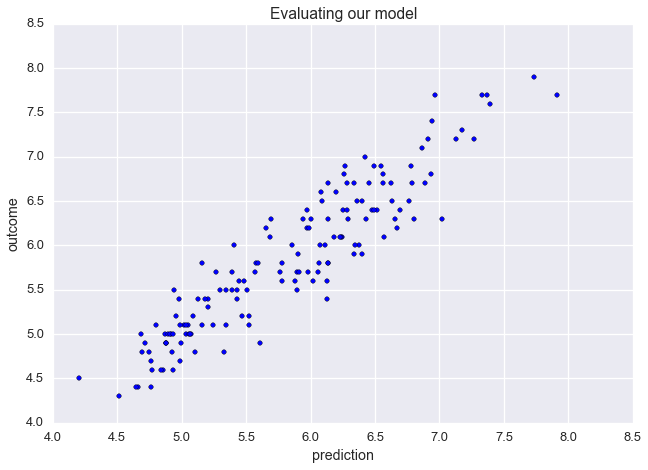

In [8]:
iris['sepal_length_hat'] = lin_model.predict(iris)

f, ax = plt.subplots()

ax.scatter(iris['sepal_length_hat'], iris['sepal_length'])
ax.set_xlabel('prediction')
ax.set_ylabel('outcome')
ax.set_title('Evaluating our model')

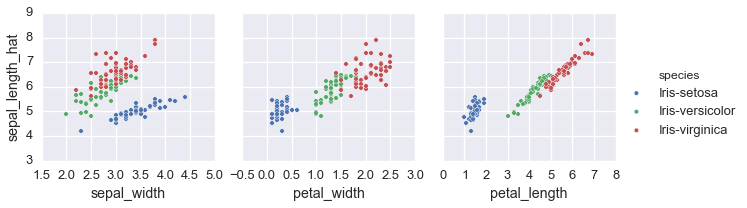

In [9]:
sns.pairplot(iris, hue='species', y_vars=['sepal_length_hat'], 
             x_vars=['sepal_width', 'petal_width', 'petal_length'])

# Logistic regression on the Titanic dataset

Let's also try to predict survival on the titanic using logistic regression.

In [10]:
df = pd.read_csv('data/titanic.csv').drop(['PassengerId', 'Ticket', 'Cabin', 'Age'], 1)
df.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,0,0,8.0500,S


We note that there are some missing values:

In [11]:
df.isnull().sum(0)

Survived    0
Pclass      0
Name        0
Sex         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

So let's get rid of them:

In [12]:
df = df.dropna()

In [13]:
log_model = smf.logit('Survived ~ C(Pclass) + Sex + C(Pclass):Sex', df).fit()
log_model.summary()

Optimization terminated successfully.
         Current function value: 0.448800
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 May 2015   Pseudo R-squ.:                  0.3254
Time:                        18:39:34   Log-Likelihood:                -398.98
converged:                       True   LL-Null:                       -591.41
                                        LLR p-value:                 5.452e-81
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      3.3900      0.587      5.775      0.000         2.240     4.541
C(Pclass)[T.2]                -0.9333      0.725     -1.287      0.198        -2.354     0.488
C(Pclass)[T.3]                -3.3900      0.610     -5.556      0.000        -4.586    -2.194
Sex[T.male]                   -3.9272      0.616     -6.373      0.000        -5.135    -2.719
C(Pclass)[T.2]:Sex[T.male]    -0.2072      0.794     -0.261      0.794        -1.764     1.349
C(Pclass)[T.3]:Sex[T.male]     2.0735      0.657      3.154      0.002         0.785     3.362
==============================================================================================
"""

In [14]:
df['Survived_hat'] = log_model.predict(df)

In [15]:
df.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,Survived_hat
0,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S,0.135447
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C,0.967391
2,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,S,0.500000
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,53.1000,S,0.967391
4,0,3,"Allen, Mr. William Henry",male,0,0,8.0500,S,0.135447
